# Libraries and Python Versions

| Name       | Version Number |
|------------|----------------|
| Python     | 3.11.4         |
| NumPy      | 1.24.3         |
| SciPy      | 1.11.3         |
| Matplotlib |  3.6.0         |


In [1]:
import numpy                as np
import matplotlib.pyplot    as plt

from   matplotlib       import cm
from   pathlib          import Path
from   matplotlib.lines import Line2D
from   scipy.optimize   import fminbound
#
### Local library pySCO
#
from pysco import read
from pysco import thermo

# 1. ${\Delta E}_\mathrm{sco}$ and $T_{1/2}$ for [Fe(*t*Bu$_2$qsal)$_2$]

In [2]:
#
### Locate source files
#
imhere    = Path.cwd()
#
### Read data for the low- and high-spin states
#
low_spin  = read.vasp( imhere/"LLLL" )
high_spin = read.vasp( imhere/"HHHH" )
#
### Compute spin-crossover energy and transition temperature
#
Esco      = thermo.spin_crossover_energy(  ls=low_spin, hs=high_spin, zero_point_energy=True )
Ehl       = thermo.spin_crossover_energy(  ls=low_spin, hs=high_spin, zero_point_energy=False )
Thalf, dH, dS = thermo.transition_temperature( ls=low_spin, hs=high_spin, dH_and_dS=True )
#
### Print results
#
print( f"The spin-crossover energy  is \033[1m{Esco:5.2f} kJ/mol\033[0m with the zero-point correction" )
print( f"The spin-crossover energy  is \033[1m{Ehl:5.2f} kJ/mol\033[0m without the zero-point correction" )
print( f"The transition temperature is \033[1m{Thalf:5.1f} K\033[0m" )

print( f"The enthalpy change is \033[1m{dH:5.4f} kJ/mol\033[0m. The entropy change is \033[1m{dS:5.4f} J/mol.K\033[0m" )

The spin-crossover energy  is  3.21 kJ/mol with the zero-point correction
The spin-crossover energy  is  9.83 kJ/mol without the zero-point correction
The transition temperature is 132.3 K
The enthalpy change is 12.1652 kJ/mol. The entropy change is 91.9785 J/mol.K


# 2. Phenomenological Interaction Parameter

In [3]:
#
### Start empty list for intermediate spins
#
mid_spins = []
#
### Define list with configuration choices
#
configs   = [ "LLLH", "LHLH", "HLHL", "HHHL" ]
#
### Read data for each configuration
#
for i in configs:
    mid_spins.append( read.vasp( imhere/f"{i}" ) )
#
### Compute interaction paramenter using a least squares fit
#
interaction, R2 = thermo.interaction_parameter(
                      ls = low_spin,
                      hs = high_spin,
                      ms = mid_spins
                  )
#
### Print result
#
print( f"The interaction parameter is \033[1m{interaction:4.2f} kJ/mol\033[0m with R^2 = {R2:.2f}" )

The interaction parameter is 2.28 kJ/mol with R^2 = 0.83


## 2.1 Fit Hysteresis Width to Experimental Value of 12 K

In [4]:
#
### Difference between computed and reference hyesteresis width
#
def hysteresis_width( interaction, ls=None, hs=None, reference=None ):
    
    T_and_nhs = thermo.high_spin_population( ls=ls, hs=hs, interaction=interaction )
    
    T_max     = np.max( T_and_nhs[ T_and_nhs[:,1]<0.5 ][:,0] )
    T_min     = np.min( T_and_nhs[ T_and_nhs[:,1]>0.5 ][:,0] )
    
    abs_error = abs( reference - T_max + T_min )
    
    print( f"{interaction = :.6f}, {abs_error = :.4f}" )
        
    return abs_error
#
### Solve numerically (SciPy may take a minute)
#
Gamma = fminbound( hysteresis_width, 3.9, 4.1, args=[ low_spin, high_spin, 12.0 ], maxfun=25 )
#
### Print result
#
print( f"\nThe fitted interaction is \033[1m{Gamma:4.2f} kJ/mol\033[0m" )

interaction = 3.976393, abs_error = 0.5386
interaction = 4.023607, abs_error = 0.1233
interaction = 4.052786, abs_error = 0.1357
interaction = 4.036439, abs_error = 0.0094
interaction = 4.037824, abs_error = 0.0029
interaction = 4.043539, abs_error = 0.0536
interaction = 4.038365, abs_error = 0.0077
interaction = 4.037466, abs_error = 0.0003
interaction = 4.037073, abs_error = 0.0038
interaction = 4.037477, abs_error = 0.0002
interaction = 4.037567, abs_error = 0.0006
interaction = 4.037511, abs_error = 0.0001
interaction = 4.037506, abs_error = 0.0001
interaction = 4.037498, abs_error = 0.0000
interaction = 4.037494, abs_error = 0.0000
interaction = 4.037501, abs_error = 0.0000

The fitted interaction is 4.04 kJ/mol


# Figure S1. Thermal Variation of $\chi\, T$ wrt the Interaction Parameter

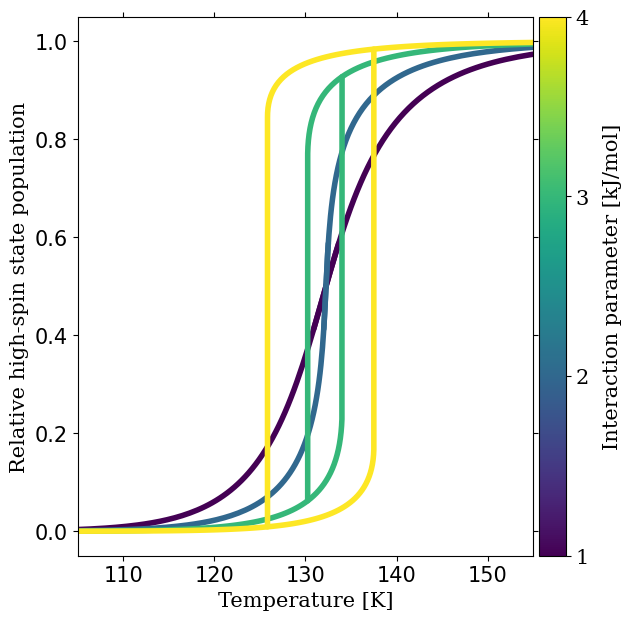

In [5]:
#
### Separate cooling and heating paths
#
def hysteresis( T_and_nhs ):
    
    T_and_nhs = np.asarray( T_and_nhs )
    
    max_hyst  = np.max( T_and_nhs[ T_and_nhs[:,1]<0.6 ][:,0] )
    min_hyst  = np.min( T_and_nhs[ T_and_nhs[:,1]>0.4 ][:,0] )
    
    max_idx   = np.where( T_and_nhs[:,0] == max_hyst )[0][0]
    min_idx   = np.where( T_and_nhs[:,0] == min_hyst )[0][0]

    min_intrp = np.interp( min_hyst, T_and_nhs[:max_idx][:,0], T_and_nhs[:max_idx][:,1] )
    max_intrp = np.interp( max_hyst, T_and_nhs[min_idx:][:,0], T_and_nhs[min_idx:][:,1] )

    min_curve = np.concatenate(( [[min_hyst, min_intrp]], T_and_nhs[min_idx:] ))
    max_curve = np.concatenate(( T_and_nhs[:max_idx], [[max_hyst, max_intrp]] ))
    
    return min_curve, max_curve
#
### Start empty list for temperature and relative high-spin population
#
T_and_nhs    = []
#
### Define interactions list
#
interactions = np.arange( start=1.0, stop=5.0, step=1.0 )
#
### Compute high-spin population for each interaction
#
for interaction in interactions:
    T_and_nhs_hysteresis = thermo.high_spin_population(
        ls=low_spin, hs=high_spin, interaction=interaction
    )

    T_and_nhs.append( T_and_nhs_hysteresis )
#
### Plot results
#
T_and_nhs   = np.asarray( T_and_nhs )

normgamma   = interactions - np.min( interactions )
normgamma   = normgamma/np.max( normgamma )

colormaping = cm.get_cmap( "viridis" )

font        = { "family":"serif", "weight":"normal", "size":15 } 

fig, ax     = plt.subplots( 1,figsize=(7,7) )

plt.rc( "font", **font )

ax.set_xlim( 105,155 )

ax.set_xlabel( "Temperature [K]", fontdict=font )
ax.set_ylabel( "Relative high-spin state population", fontdict=font )

ax.tick_params( axis="x", labelsize=font["size"], top=True, bottom=True )
ax.tick_params( axis="y", labelsize=font["size"], left=True, right=True )

for idx, i in enumerate( normgamma ):
    min_nhs, max_nhs = hysteresis( T_and_nhs[idx] )

    ax.plot( min_nhs[:,0], min_nhs[:,1], max_nhs[:,0], max_nhs[:,1], color=colormaping(i),
             label=None, ls="solid", lw=4, solid_capstyle="round" )

dummy = ax.scatter( T_and_nhs[idx][:,0], T_and_nhs[idx][:,1],
                    c=T_and_nhs[idx][:,0].size*[0.5], cmap="viridis", label=None,
                    linewidths=0, marker=None, s=0,
                    vmin=np.min(interactions), vmax=np.max(interactions) )

cbar  = plt.colorbar( mappable=dummy, ax=ax, pad=0.01, ticks=interactions )

cbar.set_label( "Interaction parameter [kJ/mol]", labelpad=10, fontdict=font )

for i in cbar.ax.get_yticklabels(): i.set_fontsize( font["size"] )
#
### Show plot
#
plt.show()

# Figure S2. Isothermal Variation of $G$ wrt the Interaction Parameter

The critical value for the interaction is 2.20 kJ/mol


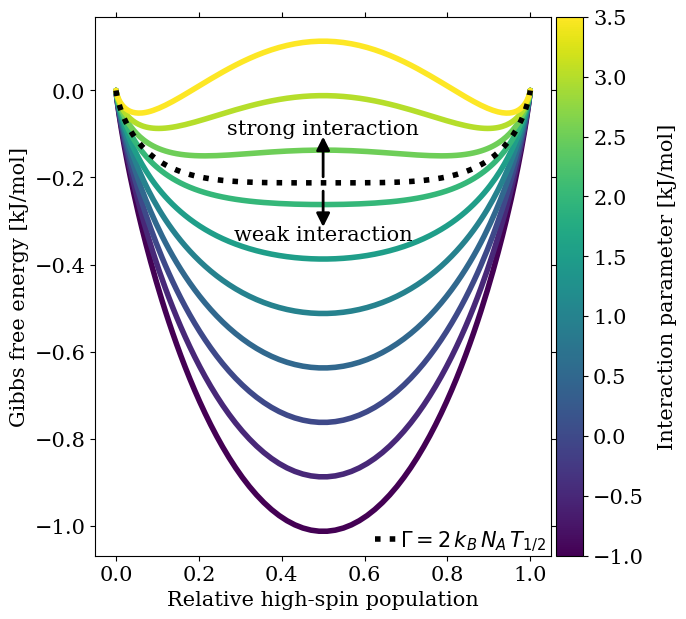

In [6]:
#
### Define k_b times N_A
#
kB_times_NA    = 1e-03*1.38064852e-23*6.02214e23 # kJ/mol
#
### Define values for weak, abrupt, and strong spin conversions
#
critical_point = 2.0*kB_times_NA*Thalf
#
### Start empty list for the relative high-spin population and Gibbs free energy
#
nhs_and_G    = []
#
### Define interactions list
#
interactions = np.arange( start=-1.0, stop=4.0, step=0.5 )
#
### Compute high-spin population for each interaction
#
for interaction in interactions:
    nhs_and_G_hysteresis = thermo.regular_solution_model(
        ls=low_spin, hs=high_spin, temperature=Thalf, interaction=interaction
    )

    nhs_and_G.append( nhs_and_G_hysteresis )
    
nhs_and_G_critical_point = thermo.regular_solution_model(
    ls=low_spin, hs=high_spin, temperature=Thalf, interaction=critical_point
)
#
### Print the critical value for the interaction parameter
#
print( f"The critical value for the interaction is \033[1m{critical_point:4.2f} kJ/mol\033[0m" )
#
### Plot results
#
nhs_and_G   = np.asarray( nhs_and_G )

normgamma   = interactions - np.min( interactions )
normgamma   = normgamma/np.max( normgamma )

colormaping = cm.get_cmap( "viridis" )

font        = { "family":"serif", "weight":"normal", "size":15 }

fig, ax     = plt.subplots( 1,figsize=(7,7) )

plt.rc( "font", **font )

ax.set_ylabel( "Gibbs free energy [kJ/mol]",    fontdict=font )
ax.set_xlabel( "Relative high-spin population", fontdict=font )

ax.tick_params( axis="x", labelsize=font["size"], top=True, bottom=True )
ax.tick_params( axis="y", labelsize=font["size"], left=True, right=True )

for idx, i in enumerate( normgamma ):
    ax.plot( nhs_and_G[idx][:,0], nhs_and_G[idx][:,1], color=colormaping(i),
             label=None, ls="solid", lw=4, solid_capstyle="round" )

ax.plot( nhs_and_G_critical_point[:,0], nhs_and_G_critical_point[:,1], color="k",
         label=None, ls="dotted", lw=4, solid_capstyle="round" )

dummy = ax.scatter( nhs_and_G[idx][:,0], nhs_and_G[idx][:,1],
                    c=nhs_and_G[idx][:,0].size*[0.5], cmap="viridis", label=None,
                    linewidths=0, marker=None, s=0,
                    vmin=np.min(interactions), vmax=np.max(interactions) )

cbar  = plt.colorbar( mappable=dummy, ax=ax, pad=0.01, ticks=interactions )

cbar.set_label( "Interaction parameter [kJ/mol]", labelpad=10, fontdict=font )

for i in cbar.ax.get_yticklabels(): i.set_fontsize( font["size"] )

arrowprops = dict( arrowstyle="-|>", color="k", linewidth=2, linestyle="solid", mutation_scale=20 )

ax.annotate( "", xytext=(0.50, -0.205), xy=(0.50, -0.10), arrowprops=arrowprops )
ax.annotate( "", xytext=(0.50, -0.225), xy=(0.50, -0.32), arrowprops=arrowprops )

ax.text( s="strong interaction", x=0.50, y=-0.11, ha="center", va="bottom", fontdict=font )
ax.text( s="weak interaction",   x=0.50, y=-0.31, ha="center", va="top", fontdict=font )

ax.legend( handles=[ Line2D([0], [0], label="$\Gamma = 2\,k_B\,N_A\,T_{1/2}$", lw=4,
                            color="k", linestyle="dotted", marker="none") ],
           frameon=False, bbox_to_anchor=(1.03, -0.03), loc="lower right", handlelength=1,
           handletextpad=0.2, fontsize=font["size"] )
#
### Show plot
#
plt.show()

# Figure S3. Variation of $G$ wrt the Interaction Parameter for Varying Temperatures around $T_{1/2}$

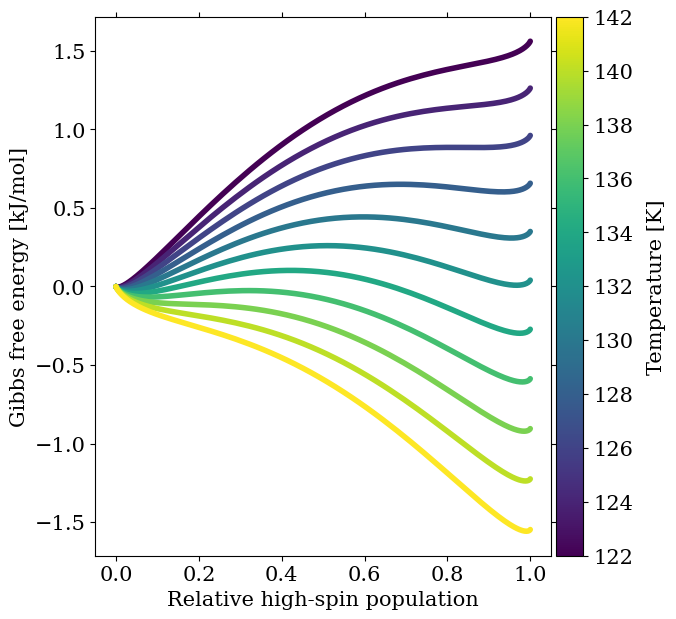

In [7]:
#
### Start empty list for the relative high-spin population and Gibbs free energy
#
nhs_and_G    = []
#
### Define temperatures list
#
temperatures = np.arange( start=122.0, stop=144, step=2.0 )
#
### Compute high-spin population for each interaction
#
for temperature in temperatures:
    nhs_and_G_hysteresis = thermo.regular_solution_model(
        ls=low_spin, hs=high_spin, temperature=temperature, interaction=4.0
    )

    nhs_and_G.append( nhs_and_G_hysteresis )
#
### Plot results
#
nhs_and_G   = np.asarray( nhs_and_G )

normtemp    = temperatures - np.min( temperatures )
normtemp    = normtemp/np.max( normtemp )

colormaping = cm.get_cmap( "viridis" )

font        = { "family": "serif", "weight": "normal", "size": 15 }

fig, ax     = plt.subplots( 1, figsize=(7,7) )

plt.rc( "font", **font )

ax.set_ylabel( "Gibbs free energy [kJ/mol]",    fontdict=font )
ax.set_xlabel( "Relative high-spin population", fontdict=font )

ax.tick_params( axis="x", labelsize=font["size"], top=True, bottom=True )
ax.tick_params( axis="y", labelsize=font["size"], left=True, right=True )

for idx, i in enumerate( normtemp ):
    ax.plot( nhs_and_G[idx][:,0], nhs_and_G[idx][:,1], color=colormaping(i),
             label=None, ls="solid", lw=4, solid_capstyle="round" )

dummy = ax.scatter( nhs_and_G[idx][:,0], nhs_and_G[idx][:,1],
                    c=nhs_and_G[idx][:,0].size*[0.5], cmap="viridis", label=None,
                    linewidths=0, marker=None, s=0, vmin=np.min(temperatures), vmax=np.max(temperatures) )

cbar = plt.colorbar( mappable=dummy, ax=ax, pad=0.01, ticks=temperatures )

cbar.set_label( "Temperature [K]", labelpad=10, fontdict=font )

for i in cbar.ax.get_yticklabels(): i.set_fontsize( font["size"] )
#
### Show plot
#
plt.show()